# Time Maps

inspiration from https://districtdatalabs.silvrback.com/time-maps-visualizing-discrete-events-across-many-timescales

In [1]:
import os; os.sys.path.append(os.path.dirname(os.path.abspath('.'))) # for relative imports
from utils.nab_data import NABData
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
data = NABData()
data.summary().head()

,file,length,features,period,periods_vary,min,max,mean,std,25th_percentile,50th_percentile,75th_percentile
0,art_daily_small_noise,4032,1,5m,1,18,87.98,42.44,28.08,19.84,21.61,75.45
1,art_daily_perfect_square_wave,4032,1,5m,1,20,80.00,42.50,29.05,20.00,20.00,80.00
2,art_daily_no_noise,4032,1,5m,1,20,80.00,42.50,27.95,20.00,20.29,79.62
3,art_noisy,4032,1,5m,1,8,19.00,13.49,3.15,10.79,13.45,16.23
4,art_flatline,4032,1,5m,1,45,45.00,45.00,0.00,45.00,45.00,45.00


In [7]:
data.data.keys()

['art_daily_small_noise',
 'art_daily_perfect_square_wave',
 'art_daily_no_noise',
 'art_noisy',
 'art_flatline',
 'TravelTime_387',
 'occupancy_t4013',
 'speed_7578',
 'TravelTime_451',
 'speed_t4013',
 'occupancy_6005',
 'speed_6005',
 'Twitter_volume_UPS',
 'Twitter_volume_AAPL',
 'Twitter_volume_IBM',
 'Twitter_volume_CVS',
 'Twitter_volume_PFE',
 'Twitter_volume_GOOG',
 'Twitter_volume_FB',
 'Twitter_volume_CRM',
 'Twitter_volume_KO',
 'Twitter_volume_AMZN',
 'nyc_taxi',
 'cpu_utilization_asg_misconfiguration',
 'machine_temperature_system_failure',
 'rogue_agent_key_updown',
 'ambient_temperature_system_failure',
 'ec2_request_latency_system_failure',
 'rogue_agent_key_hold',
 'art_load_balancer_spikes',
 'art_daily_flatmiddle',
 'art_increase_spike_density',
 'art_daily_nojump',
 'art_daily_jumpsdown',
 'art_daily_jumpsup',
 'exchange-2_cpc_results',
 'exchange-3_cpc_results',
 'exchange-4_cpc_results',
 'exchange-4_cpm_results',
 'exchange-3_cpm_results',
 'exchange-2_cpm_resul

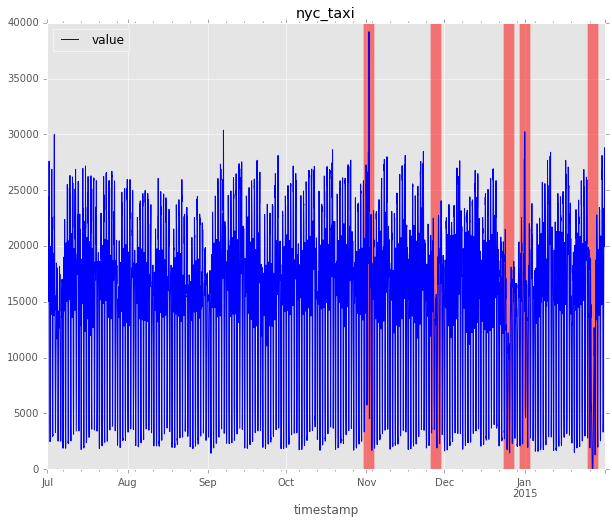

In [8]:
data.plot('nyc_taxi')

the example in the blog post is for a heat map of the amount of time in between events in a sequence.

/home/jstrong/src/envs/tmetrics/lib/python2.7/site-packages/ipykernel/__main__.py:24: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


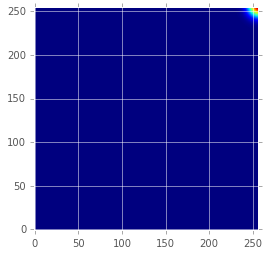

In [11]:
import scipy.ndimage as ndi

df = data['nyc_taxi']

times = df.index

# calculate time differences:
diffs = np.diff(times)

xcoords = diffs[:-1] # all differences except the last
ycoords = diffs[1:] # all differences except the first

Nside=256 # this is the number of bins along x and y for the histogram
width=8 # the width of the Gaussian function along x and y when applying the blur operation

H = np.zeros((Nside,Nside)) # a 'histogram' matrix that counts the number of points in each grid-square

max_diff = np.max(diffs) # maximum time difference

x_heat = (Nside-1)*xcoords/max_diff # the xy coordinates scaled to the size of the matrix
y_heat = (Nside-1)*ycoords/max_diff # subtract 1 since Python starts counting at 0, unlike Fortran and R

for i in range(len(xcoords)): # loop over all points to calculate the population of each bin
    H[x_heat[i], y_heat[i]] += 1 # Increase count by 1
    #here, the integer part of x/y_heat[i] is automatically taken

H = ndi.gaussian_filter(H,width) # apply Gaussian blur
H = np.transpose(H) # so that the orientation is the same as the scatter plot

plt.imshow(H, origin='lower') # display H as an image
plt.show()

Our data file includes equal intervals, so this approach is worthless

In [13]:
len(set(np.diff(data['nyc_taxi'].index)))

1

However, perhaps the axes could reflect time of day and day of week to show mean values for those instead.

In [14]:
df.head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820


This data file is every 30 mins...

In [15]:
df.index[0].weekday()

1

In [24]:
np.unique(df.index.map(lambda x: x.weekday()))

array([0, 1, 2, 3, 4, 5, 6])

In [18]:
days_legend = dict(zip(range(7), ['Mon','Tue','Wed','Thur','Fri','Sat','Sun']))
days_legend

{0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thur', 4: 'Fri', 5: 'Sat', 6: 'Sun'}

In [19]:
day_masks = dict(zip(range(7), [df.index.map(lambda x: x.weekday() == d) for d in range(7)]))
df.loc[day_masks[0]].shape

(1440, 1)

In [29]:
times = np.unique(df.index.map(lambda x: x.time()))

In [30]:
tindex = df.index.map(lambda x: x.time())
time_masks = dict(zip(times, [(tindex == t) for t in times]))
k = time_masks.keys()[0]
print k
print df.loc[time_masks[k]].shape

03:30:00
(215, 1)


In [61]:
dtmap = pd.DataFrame(np.zeros((len(time_masks), len(day_masks))), index=sorted(times), columns=range(7))
print dtmap.shape
fn = np.mean

for day, daymask in day_masks.iteritems():
    for time, timemask in time_masks.iteritems():
        val = fn(df.loc[daymask & timemask])
        dtmap.loc[time, day] = val.values

dtmap.head()

(48, 7)


,0,1,2,3,4,5,6
00:00:00,9036.700000,9636.129032,12001.451613,14041.774194,17392.387097,23733.612903,24564.133333
00:30:00,7003.866667,7331.290323,9087.870968,11355.225806,14489.709677,22252.516129,23233.333333
01:00:00,5358.866667,5740.354839,7118.903226,9082.193548,11836.870968,20739.806452,22554.300000
01:30:00,4140.633333,4316.032258,5426.354839,7182.935484,9350.290323,18836.677419,20632.766667
02:00:00,3486.000000,3440.032258,4418.000000,5941.387097,7673.354839,17406.677419,18635.933333


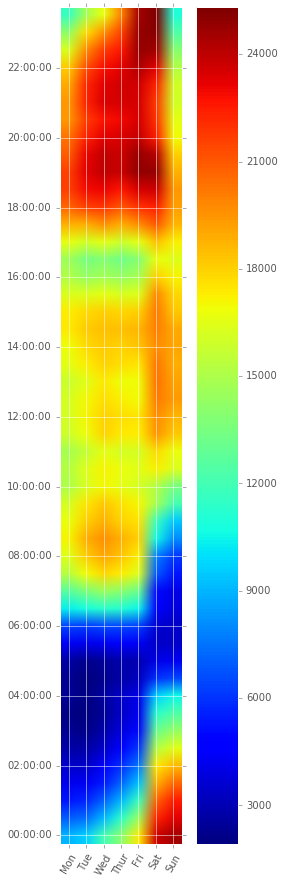

In [63]:
fig = plt.figure(figsize=(5, 15))
plt.imshow(dtmap, origin='lower') # display H as an image
plt.yticks(range(dtmap.shape[0])[::4], sorted(times)[::4])
plt.xticks(range(7), [days_legend[x] for x in range(7)], rotation=60)
plt.colorbar()
plt.show()

There - we have a highly informative quick glance at the data. The most activity occurs in the late evenings. The weekends are pushed back a few hours from week days. And so on.